In [191]:
import numpy as np
import matplotlib.pyplot as plt
import qrcode
from PIL import Image

In [316]:
SECRET = 'rispro'

def generate_watermark(data,secret,quant=16,size=(100,100),rprop=100):
    dist  = [0 if i==0 else int(i*256/quant)-1 for i in range(quant+1)]
    np.random.seed(abs(hash(data+secret))%2**32)
    p=np.random.choice([i for i in range(rprop)], size = quant+1)
    p=p/p.sum()
    watermark = np.random.choice(dist,size=size,p=p)
    return watermark.astype('uint8')

def make_secureQR(data:str,secret:str=SECRET,                  
                  pct_wm_size:int=0.3, 
                  bx_size:int=10,
                  border:int=4,
                  qr_ver:int=None,
                  **kwargs)-> np.ndarray:

    img = qrcode.make(data,version=qr_ver, box_size=bx_size, border=border, error_correction=qrcode.constants.ERROR_CORRECT_H)
    img = np.asanyarray(img).astype('uint8')*255
    
    wm_size = (img.shape[0]//bx_size - 2*border) * pct_wm_size
    wm_size = int(wm_size)
    if not wm_size%2==0: wm_size-=1 

    wm_size *= bx_size
    size = (wm_size,wm_size)
    watermark = generate_watermark(data,secret,size=size,**kwargs)
    wm = np.pad(watermark, bx_size//2, constant_values=255)

    # add border watermark 8
    length = wm.shape[0] 
    loc = img.shape[0]//2 - length//2
    img[loc:loc+length,loc:loc+length]= wm
    return img, watermark

import cv2
import numpy as np
from scipy.special import rel_entr
from scipy.spatial import distance

def read_sqr(im):
    qrDecoder = cv2.QRCodeDetector()
    myqr = qrDecoder.detectAndDecode(im)
    top = myqr[1][0][0].astype(int)
    bottom = myqr[1][0][2].astype(int)+1
    qim = im[top[0]:bottom[0],top[1]:bottom[1]].astype(float)

    # # normalize
    qim -= qim.min()
    qim *= 255/qim.max()

    return myqr[0],qim

def JS_div(p,q):
    m = (p+q)/2
    div = 0.5*rel_entr(p,m) + 0.5*rel_entr(q,m)
    return div.sum()

def compute_KL(qim,scan,quant=16,pct=0.2,metric='JS'):
    pq = []
    for q in [qim,scan]:
        l = q.shape[0]
        half = l//2
        r = int(0.5*pct*l)             
        wtm = q[half-r:half+r,half-r:half+r]
        dist, *note = np.histogram(wtm.ravel(),bins=quant)
        p = dist/dist.sum()
        pq.append(p)        
    return rel_entr(*pq).sum() if metric=="KL" else distance.jensenshannon(*pq), pq  

def compare2template(im, qr_ver = 3, quant=16, pct=0.2, metric='JS'):
    data ,qim = read_sqr(im) 
    img,_ = make_secureQR(data, qr_ver = qr_ver, quant=quant)
    _,qim_scan = read_sqr(img) 
    return (data,)+compute_KL(qim,qim_scan,quant,pct,metric)

In [313]:
# generate batch of images
import pathlib
import numpy as np
from pathlib import Path

def generate_batch(path):
    path =Path(path)
    rows = []
    for i in range(100): 
        print(i,end=' ')
        for j in range(2):
            col = []
            for k in range(5):
                img,wtm = make_secureQR(f'data_{i+1:03}',qr_ver = 3, quant=16)
                col.append(img)
            rows.append(np.hstack(col))
        if (i+1)%4 ==0:
            rows.append(np.ones((10,rows[0].shape[1]),dtype='uint8'))
            grid = np.vstack(rows)

            Image.fromarray(grid).save(path/f"{i-2:03}_{i+1}.pdf")
            rows=[]

In [ ]:
generate_batch("watermark")

# Test single case

(80, 80)


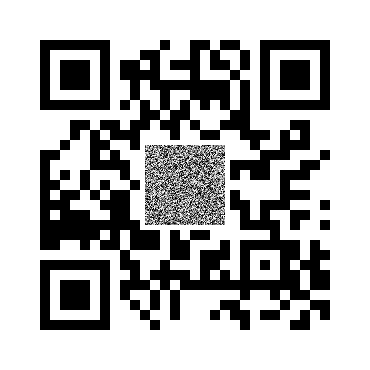

In [314]:
img,wtm = make_secureQR("halo0001", qr_ver = 3, quant=16)
im = Image.fromarray(img)
print(wtm.shape)
im

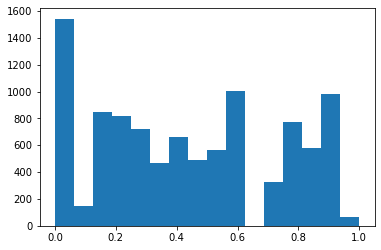

In [292]:
# All watermark
dist, *note = plt.hist(wtm.ravel()/wtm.max(),bins=16)
P = dist/dist.sum()


In [293]:
np.histogram(_wtm.ravel()/_wtm.max(),bins=16)

(array([384,  43, 207, 199, 165, 104, 190, 120, 159, 257,   0,  75, 195,
        147, 242,  13], dtype=int64),
 array([0.    , 0.0625, 0.125 , 0.1875, 0.25  , 0.3125, 0.375 , 0.4375,
        0.5   , 0.5625, 0.625 , 0.6875, 0.75  , 0.8125, 0.875 , 0.9375,
        1.    ]))

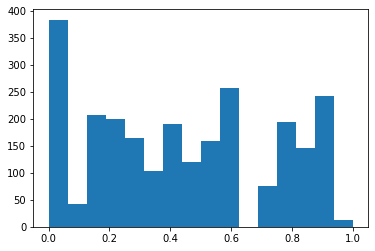

In [264]:
# subset watermark
c = wtm.shape[0]//2
idx = slice(c-25,c+25)
_wtm = wtm[idx,idx]

dist2, *note = plt.hist(_wtm.ravel()/_wtm.max(),bins=16)
Q = dist2/dist2.sum()


In [265]:
from scipy.special import kl_div
kl_div(P,Q).sum()


0.0023643875735848124

# Read QR

('halo',
 0.0,
 [array([0.0648038 , 0.02140309, 0.11652794, 0.08977408, 0.01664685,
         0.11504162, 0.03983353, 0.00118906, 0.00713436, 0.132283  ,
         0.09542212, 0.00505351, 0.08769322, 0.07401902, 0.10196195,
         0.03121284]),
  array([0.0648038 , 0.02140309, 0.11652794, 0.08977408, 0.01664685,
         0.11504162, 0.03983353, 0.00118906, 0.00713436, 0.132283  ,
         0.09542212, 0.00505351, 0.08769322, 0.07401902, 0.10196195,
         0.03121284])])

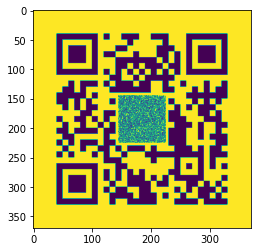

In [318]:
# im = Image.open("qr2.png")
im,wtm = make_secureQR("halo", qr_ver = 3, quant=16)
plt.imshow(im)
compare2template(im,pct=0.2)


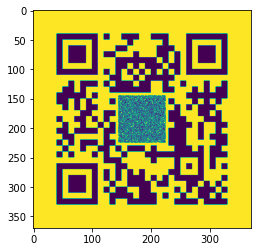

In [302]:
plt.imshow(im)

In [306]:
from pyzbar.pyzbar import decode
im = Image.open("watermark/001_4.png")
decode(im)

[]

In [281]:
im = Image.open("watermark\001_4.png")
qrDecoder = cv2.QRCodeDetector()
myqr = qrDecoder.detectAndDecode(np.asanyarray(im))
myqr

('',
 array([[[ 40.,  40.],
         [329.,  40.],
         [329., 329.],
         [ 40., 329.]]], dtype=float32),
 None)

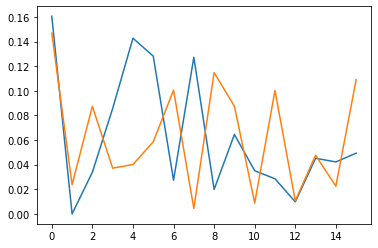

In [244]:
plt.plot(x[0])
plt.plot(x[1])

# Old Code

In [11]:
from PIL import Image
im = Image.fromarray(img)
im.save('qr1.pdf')

In [18]:
# 1 inch = 25.4 mm
img.shape[0]

370

In [33]:
p = 370//2-50
imm = img[p:p+100,p:p+100]

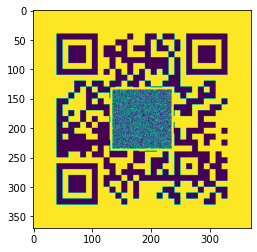

In [32]:
plt.imshow(img)

(array([1565., 1270., 1196.,  679.,  599.,  340.,  156., 1048.,  731.,
         338.,  765., 1013.,   83.,  145.,    0.,   72.]),
 array([0.    , 0.0625, 0.125 , 0.1875, 0.25  , 0.3125, 0.375 , 0.4375,
        0.5   , 0.5625, 0.625 , 0.6875, 0.75  , 0.8125, 0.875 , 0.9375,
        1.    ]),
 <BarContainer object of 16 artists>)

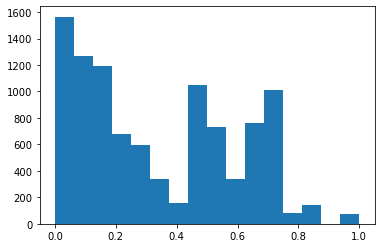

In [34]:
plt.hist(imm.ravel()/imm.max(),bins=16)

(array([57., 48., 46., 28., 27., 14.,  7., 46., 30., 11., 32., 41.,  2.,
         9.,  0.,  2.]),
 array([0.    , 0.0625, 0.125 , 0.1875, 0.25  , 0.3125, 0.375 , 0.4375,
        0.5   , 0.5625, 0.625 , 0.6875, 0.75  , 0.8125, 0.875 , 0.9375,
        1.    ]),
 <BarContainer object of 16 artists>)

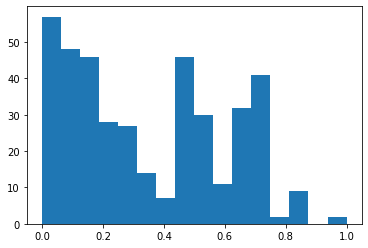

In [35]:
sub = imm[40:-40,40:-40]
plt.hist(sub.ravel()/sub.max(),bins=16)


In [131]:
im = np.random.randint(0,255,size=(100,100))
  

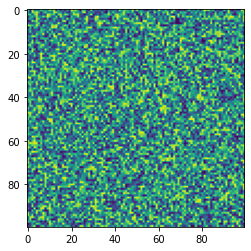

In [132]:
plt.imshow(im)